# Lyft Bay Wheels Data Exploration
## by Claire Li

## Investigation Overview

This project uses trip data from Lyft's Bay Wheels, a bikeshare service based in San Francisco, CA. The goal of this project is to glean insights about the service from the dataset using data visualizations. Specifically, I investigated peak hours, ride details, and rider information. 

## Dataset Overview

The dataset (taken from [Lyft's website](https://www.lyft.com/bikes/bay-wheels/system-data)) included all Bay Wheels rides made in May 2020. Features included in the dataset were: ride ID, type of bike, start and end time/date, start and end station ID, start and end station name, start and end station coordinates, and user type.   



In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import folium 
from geopy import distance
import datetime as dt

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
#load csv 
baywheels = pd.read_csv('baywheels2.csv')

In [4]:
#Fix data types
baywheels['duration'] = pd.to_timedelta(baywheels['duration'])
baywheels['started_at'] = pd.to_datetime(baywheels['started_at'])
baywheels['ended_at'] = pd.to_datetime(baywheels['ended_at'])

days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
day_type = pd.api.types.CategoricalDtype(ordered = True, categories = days)
baywheels['day_of_week'] = baywheels['day_of_week'].astype(day_type)

#Create new column for duration in minutes (rounds values) 
baywheels['duration_min'] = baywheels['duration'].astype('timedelta64[m]')

## Peak Hours

There is generally the highest amount of activity between **noon and 6PM** every day, with significantly more rides on the weekends **(Fri, Sat, and Sun)**. During the week, number of rides generally increases from 12PM to 5PM, and then tapers down. During the weekend, the peak occurs around 2 to 3PM. For the off-hours (e.g., 12AM-5AM, after 8PM), the number of rides is approximately the same across all days of the week. 

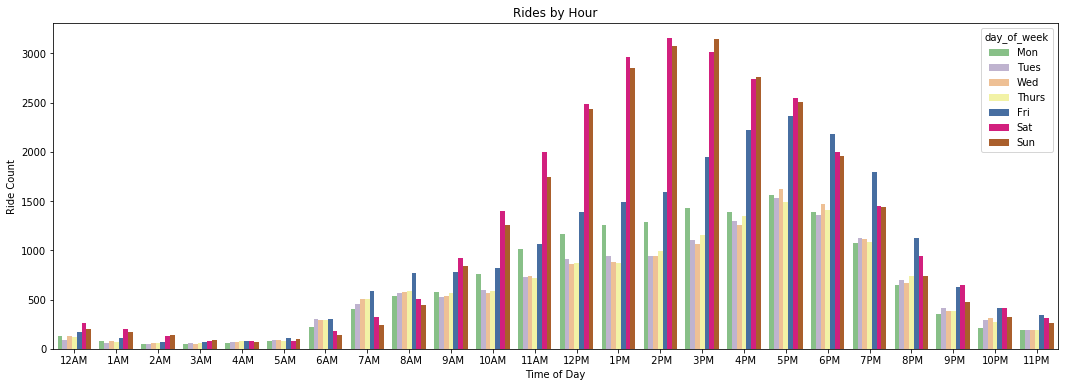

In [5]:
plt.figure(figsize = [18, 6])
sb.countplot(data = baywheels, x = 'time_of_day', hue = 'day_of_week', palette = 'Accent'); 

plt.xlabel("Time of Day"); 
ticks = np.arange(0, 24, 1)
hours = [(dt.time(i).strftime('%l%p')) for i in range(24)]
plt.xticks(ticks, hours);
plt.ylabel("Ride Count");
plt.title("Rides by Hour");

## Distribution of Stations 

Plotting the coordinates of the start stations on a map, 3 distinct geographical clusters emerge. Roughly, these are:  San Francisco, East Bay (Oakland/Berkeley), and South Bay (San Jose). 

In [6]:
sf_lat = 37.7749
sf_long = -122.4194

#for efficiency, use only the start stations with labeled names
start_stations = baywheels[~baywheels.start_station_name.isnull()]
start_stations.drop_duplicates(subset = 'start_station_name', inplace = True)

# create map of SF using latitude and longitude values
map_sf= folium.Map(location=[sf_lat, sf_long], zoom_start=10)

# add markers to map
for lat, lng, name in zip(start_stations['start_lat'], start_stations['start_lng'], start_stations['start_station_name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

## Distance vs. Duration

Most rides are under 5 miles and under 30 minutes long. Removing outliers, it was found that the typical trip lasts around **15-30 minutes** and the average distance is somewhere between **0.5 - 1.0 miles**. In general, longer rides are associated with greater distances. However, this is not always the case. This could perhaps be due to people who rent a bike and do not use it constantly through their entire rental period, or perhaps people who make a round trip and end at near where they started.

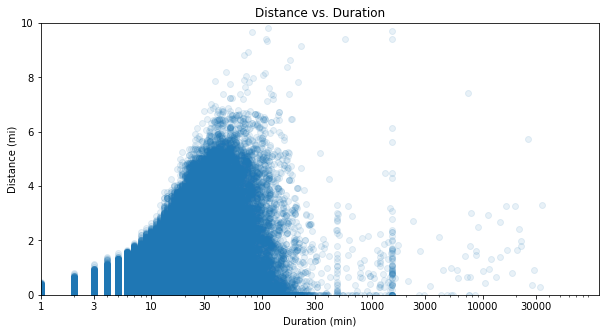

In [29]:
dist_dur = baywheels[~baywheels.distance.isnull()]
dist_dur['duration'] = dist_dur['duration'].astype('timedelta64[m]')

plt.figure(figsize = [10, 5])
plt.scatter(data = dist_dur, x = 'duration', y = 'distance', alpha = 0.1);

plt.xscale('log'); 
ticks = [1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000]
plt.xticks(ticks, ticks);
plt.ylim([0, 10]);
plt.xlabel("Duration (min)");
plt.ylabel("Distance (mi)");
plt.title("Distance vs. Duration");

## Rider Information 

Non-members form the majority of users of the Bay Wheels service. Most riders, both members and non-members, start from San Francisco. There is a large gap betwen non-members and members in San Francisco, but it seems to be about an even split between non-members and members in San Jose and Oakland/Berkeley. 

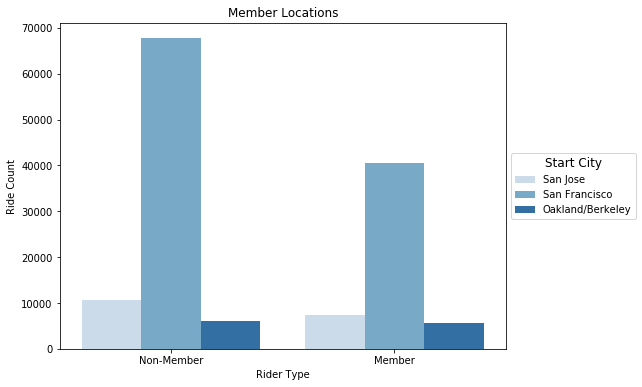

In [30]:
plt.figure(figsize = [8,6]); 
ax = sb.countplot(data = baywheels, x = 'member_casual', hue = 'start_city', palette = 'Blues');
ax.set_xticklabels(['Non-Member', 'Member']);
ax.set_xlabel("Rider Type");
ax.set_ylabel("Ride Count");
ax.set_title("Member Locations");
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title= "Start City", title_fontsize = 12, labels = ['San Jose', 'San Francisco', 'Oakland/Berkeley']);

## Average Duration and Distance

Finally, I created a clustered bar chart to examine the relationships between rider type, starting city, and average distance/duration. I found that most riders are non-members. Interestingly, non-members tend to take longer rides in all three cities. Average distance is also longer for non-members in San Jose and San Francisco, though the difference between members and non-members is less pronounced. 

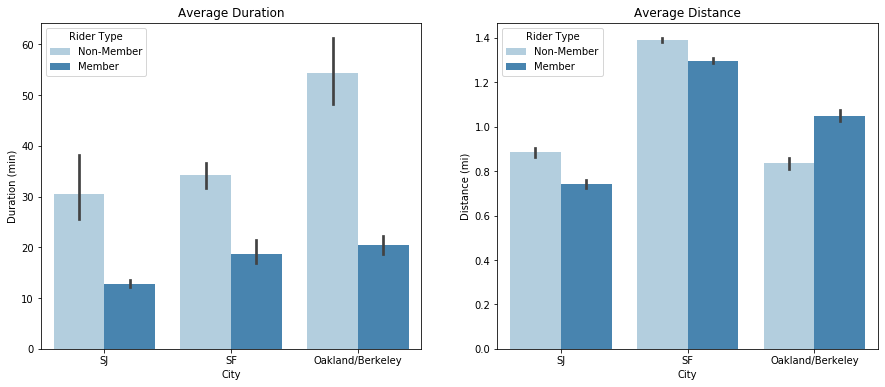

In [12]:
plt.figure(figsize = [15, 6]);

plt.subplot(1, 2, 1);
ax = sb.barplot(data = baywheels, x = 'start_city', y = 'duration_min', hue = 'member_casual', palette = 'Blues')
legend = ax.legend(loc = 2, title = 'Rider Type');
for t, l in zip(legend.texts,("Non-Member", "Member")):
    t.set_text(l)
plt.xlabel('City'); 
plt.ylabel('Duration (min)');
plt.title("Average Duration");

plt.subplot(1, 2, 2);
ax2 = sb.barplot(data = baywheels, x = 'start_city', y = 'distance', hue = 'member_casual', palette = 'Blues')
legend2 = ax2.legend(loc = 2, title = 'Rider Type');
for t, l in zip(legend2.texts,("Non-Member", "Member")):
    t.set_text(l)
plt.xlabel('City'); 
plt.ylabel('Distance (mi)');
plt.title("Average Distance");

## Conclusion 

The key takeaways from this project are:  
1. **Peak hours**: Peak hours can generally be described as being between 12PM-5PM. On weekdays, number of rides increases from 12PM - 5PM and then tapers down; on weekends, number of rides is highest at approximately 2-3PM. Weekends see higher volume of rides. 
2. **Ride details**: Rides are generally between 15-30 minutes, and 0.5-1.0 miles. Significantly more rides are taken in San Francisco than other areas, offering an opportunity for expansion. 
3. **Member information**: Most riders are casual users (i.e., non-members). Members are mostly located in San Francisco, again indicating an opportunity for expansion. 